# Import libaries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

2025-08-21 14:31:35.219324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load dataset and augmentation

In [2]:
BASE_DIR   = "Malaria-Detection/Dataset"   # Dataset/{train,val,test}/{Parasitized,Uninfected}
IMG_SIZE   = (224, 224)
BATCH_SIZE = 64
SEED       = 42
AUTOTUNE   = tf.data.AUTOTUNE

# ====== Dataset loaders ======
train_gen = tf.keras.utils.image_dataset_from_directory(
    directory = f"{BASE_DIR}/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_gen = tf.keras.utils.image_dataset_from_directory(
    directory = f"{BASE_DIR}/val",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    directory = f"{BASE_DIR}/test",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ====== Preprocessing pipeline ======
# augment chỉ áp dụng cho train
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# map pipeline: augment (chỉ train) + preprocess_input
train_gen = (
    train_gen
    .map(lambda x, y: (data_augmentation(x, training=True), y),
         num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (preprocess_input(x), y),
         num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

val_gen = (
    val_gen
    .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

test_gen = (
    test_gen
    .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

Found 22046 files belonging to 2 classes.


I0000 00:00:1755786700.408267    7885 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22162 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:61:00.0, compute capability: 8.9


Found 2756 files belonging to 2 classes.
Found 2756 files belonging to 2 classes.


# Build model

In [3]:
base = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base.trainable = False  # warm-up

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = inputs
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Train model

In [4]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6),
]

# Warm-up
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20


2025-08-21 14:31:56.962179: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c1b8000d4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-21 14:31:56.962220: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-08-21 14:31:57.070789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-21 14:31:58.671221: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-21 14:32:05.028657: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng10{k2=4,k13=0,k14=2,k18=1,k23=0} for conv (f16[64,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,224,224,3]{3,2,1,0}, f16[64,3,3,3]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cu

  5/345 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5426 - loss: 1.6349

I0000 00:00:1755786745.751968    8845 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


345/345 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.8191 - loss: 0.4848 - val_accuracy: 0.9311 - val_loss: 0.1848 - learning_rate: 0.0010
Epoch 2/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.8968 - loss: 0.2753 - val_accuracy: 0.9387 - val_loss: 0.1929 - learning_rate: 0.0010
Epoch 3/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.9092 - loss: 0.2481 - val_accuracy: 0.9387 - val_loss: 0.1768 - learning_rate: 0.0010
Epoch 4/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.9103 - loss: 0.2389 - val_accuracy: 0.9398 - val_loss: 0.1738 - learning_rate: 0.0010
Epoch 5/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.9145 - loss: 0.2367 - val_accuracy: 0.9380 - val_loss: 0.1763 - learning_rate: 0.0010
Epoch 6/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.9158 - loss: 0.2323 - val_accuracy: 0.9387 - val_loss: 0.1806 - learning_rate: 0.0010
Epoch 7/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9178 - loss: 0.2277

In [5]:
# Fine-tune
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50


2025-08-21 14:38:19.928417: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-21 14:38:26.553490: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f16[64,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,224,224,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-08-21 14:38:26.655361: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.102021675s
Trying algorithm eng0{} for conv (f16[64,

344/345 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9451 - loss: 0.1659

2025-08-21 14:40:41.364747: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=3} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[30,224,224,64]{3,2,1,0}, f16[30,224,224,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-08-21 14:40:42.392888: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.028269502s
Trying algorithm eng19{k2=3} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[30,224,224,64]{3,2,1,0}, f16[30,224,224,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"

345/345 ━━━━━━━━━━━━━━━━━━━━ 220s 277ms/step - accuracy: 0.9516 - loss: 0.1453 - val_accuracy: 0.9590 - val_loss: 0.1125 - learning_rate: 1.0000e-05
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 130ms/step - accuracy: 0.9588 - loss: 0.1188 - val_accuracy: 0.9619 - val_loss: 0.1067 - learning_rate: 1.0000e-05
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.9619 - loss: 0.1106 - val_accuracy: 0.9623 - val_loss: 0.1089 - learning_rate: 1.0000e-05
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 48s 133ms/step - accuracy: 0.9633 - loss: 0.1044 - val_accuracy: 0.9677 - val_loss: 0.0960 - learning_rate: 1.0000e-05
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.9663 - loss: 0.0964 - val_accuracy: 0.9663 - val_loss: 0.1103 - learning_rate: 1.0000e-05
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 129ms/step - accuracy: 0.9667 - loss: 0.0944 - val_accuracy: 0.9641 - val_loss: 0.0957 - learning_rate: 1.0000e-05
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 48s 133ms/step -

# Evaluate

In [6]:
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test loss: {test_loss:.4f} | acc: {test_acc:.4f}")

Test loss: 0.0851 | acc: 0.9742


# Confusion matrix

2025-08-21 15:02:27.713517: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


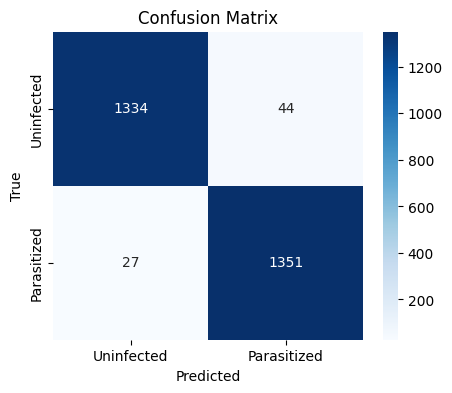

              precision    recall  f1-score   support

  Uninfected       0.98      0.97      0.97      1378
 Parasitized       0.97      0.98      0.97      1378

    accuracy                           0.97      2756
   macro avg       0.97      0.97      0.97      2756
weighted avg       0.97      0.97      0.97      2756



In [7]:
y_true = np.concatenate([y for x, y in test_gen], axis=0)              # ground truth
y_pred = model.predict(test_gen)                                       # dự đoán xác suất
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()              # chuyển sang 0/1

cm = confusion_matrix(y_true, y_pred_classes)
labels = ["Uninfected", "Parasitized"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=labels))